# 1df FTND GWAS of Nelson Data

**Author**: Jesse Marks

**GitHub Issue**: [issue 96](https://github.com/RTIInternational/bioinformatics/issues/96#issuecomment-401903152)

This document logs the steps taken to process:

[*A Genome-Wide Association Study of Heroin Dependence*](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs000277.v1.p1&phv=171252&phd=&pha=&pht=2797&phvf=&phdf=&phaf=&phtf=&dssp=1&consent=&temp=1) (Nelson data set) and perform an FTND GWAS to test for association with Nicotine Dependence (ND). This Nelson data set is a collaboration of Australian and American investigators aims to identify genes associated with liability for heroin dependence. There is FTND phenotype data included however, so we will perform a ND GWAS.

The [Fagerström Test for Nicotine Dependence (FTND](https://cde.drugabuse.gov/instrument/d7c0b0f5-b865-e4de-e040-bb89ad43202b) is a standard instrument for assessing the intensity of physical addiction to nicotine.

The data for this study are located on S3 at:

`s3://rti-midas-data/studies/heroin_icghd/`

**Note**: the imputed data for this cohort had to be reconverted. Originally, the genotype data were imputed with the impute2 software version 2.3.0. The script used to convert the `.gen` files created by impute2 to `.mldose` files, in order to be compatible with the rvtest GWAS software, was incompatible: the wrong column was reference to convert the MAF. As a result, the GWAS results were erroneous. There are currently two versions of the convert-script: one converts `.gen` files to `.mldose` format when the genotype data were imputed with a version of impute2 prior to version 2.3.2 and the other script converts the data when versions of impute2 subsequent to version 2.3.2 were used. On my EC2 instance on AWS, the scripts are located at:

```
/shared/bioinformatics/software/perl/file_conversion/convert_post-v2.3.2_impute2_files.pl
/shared/bioinformatics/software/perl/file_conversion/convert_pre-v2.3.2_impute2_files.pl
```

The Nelson Data set has been downloaded to an EC2 instance from S3 to the location:
`/shared/data/studies/Nelson`


`/shared/data/studies/Nelson/UHS_heroin`

The head of the data looks like the follow:

`head imputed.aa_pop_pheno_controls_overlap.chr1.heroin_10EVs.palogist.stats`

`name position A1 A2 Freq1 MAF Quality Rsq n Mean_predictor_allele beta_SNP_add sebeta_SNP_add loglik chi p or_95_percent_ci       chr
rs58108140 10583 G A 0.923 0.077 0 0.471 3662 0.923191 0.00656649 0.133317 -2320.59 0.00242602632930075 0.960716312898352 1.01(0.78-1.31) 1
`

Where is the phenotype file for these data? What data do I need in order to perform a gwas? What I should do is look at my old notebooks to see how I performed the GWAS and then replicate this. 

**Set autoscaling tags**

This can be done in the AWS console.

In [ ]:
aws autoscaling create-or-update-tags --tags "ResourceId=cfncluster-JMspot2-ComputeFleet-IQXOI7AVONI2,ResourceType=auto-scaling-group,Key=project-number,Value=0215457.000.001,PropagateAtLaunch=true"

In [ ]:
## EC2 ##
aws s3 sync s3://rti-midas-data/studies/heroin_icghd/ /shared/data/studies/nelson --quiet &
mkdir -p /shared/jmarks/nicotine/gwas/nelson/phenotype
cp /shared/data/studies/nelson/phenotypes/probabel/heroin_icghd.ea.CAT_FTND.AGE.SEX.ALCOHOLDEP4.EVs.v1.gz \
    /shared/jmarks/nicotine/gwas/nelson/phenotype

cd /shared/jmarks/nicotine/gwas/nelson/phenotype
gunzip heroin_icghd.ea.CAT_FTND.AGE.SEX.ALCOHOLDEP4.EVs.v1.gz

# only what to run a baseline gwas and therefore we will remove the alcohol covariate column
awk '{print $1,$2,$3,$4,$6,$7,$8, $9}' heroin_icghd.ea.CAT_FTND.AGE.SEX.ALCOHOLDEP4.EVs.v1 > nelson.ea.CAT_FTND.AGE.SEX.EVs.v1

mkdir -p ../association_test/001
cd association_tests/001

cp /shared/data/studies/nelson/imputed/v1/association_tests/003/_methods.heroin_icghd.v1.association_tests.003.sh \
    _methods.nelson.v1.association_tests.sh





## Imputation Conversion

There are some apparent issues with the `mldose` files. Specifically, the minor allele frequencies (MAF) are not lining up to what they should be. The issue was found after performing a baseline GWAS and finding that all of the results were NULL. After comparing the MAF of the `mldose` files and the `gen.gz` files, one can see that the MAF are in discordance. As an example, let us compare the MAF of SNP `rs16969968` (Mr. Big). 

```
heroin_icghd.ea.1000G_p3.chr15.21.mach.mlinfo:
SNP     Al1     Al2     Freq1   MAF     Quality Rsq
rs16969968:78882925:G:A   G       A       0.002   0.002   0       0

 heroin_icghd.ea.1000G_p3.chr15.21.gen_info
snp_id rs_id position exp_freq_a1 info certainty type info_type0 concord_type0 r2_type0
--- rs16969968:78882925:G:A 78882925 0.349 0.996 0.998 0 -1 -1 -1
```

In [ ]:
#perl /shared/bioinformatics/software/perl/file_conversion/convert_post-v2.3.2_impute2_files.pl\
dataDir=/shared/data/studies/nelson/imputed/v1/imputations/ea/chr15/sandbox

/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name impute_conversion_test \
    --script_prefix $dataDir/test2/mytest \
    --mem 15 \
    --nslots 4 \
    --priority 0 \
    --program perl /shared/bioinformatics/software/perl/file_conversion/convert_pre-v2.3.2_impute2_files.pl\
        --gen $dataDir/heroin_icghd.ea.1000G_p3.chr15.21.gen.gz \
        --sample $dataDir/heroin_icghd.ea.for_imputation.chr15.phased.sample.gz\
        --gen_info $dataDir/heroin_icghd.ea.1000G_p3.chr15.21.gen_info \
        --remove $dataDir/heroin_icghd.ea.1000G_p3.chr15.gen.remove\
        --out $dataDir/test2/heroin_icghd.ea.1000G_p3.chr15.21\
        --generate_mach_mldose_file\
        --generate_mach_mlinfo_file\
        --generate_legend_file \
        --variant_type all


## Outcome lines up
Here are the results to the script ran above. It appears that the issue was in fact the results of an erroneous version of the conversion script initially applied.

/shared/data/studies/nelson/imputed/v1/imputations/ea/chr15/sandbox/heroin_icghd.ea.1000G_p3.chr15.21.gen_info
```
snp_id rs_id position exp_freq_a1 info certainty type info_type0 concord_type0 r2_type0
--- rs16969968:78882925:G:A 78882925 0.349 0.996 0.998 0 -1 -1 -1
```

/shared/data/studies/nelson/imputed/v1/imputations/ea/chr15/sandbox/test2/heroin_icghd.ea.1000G_p3.chr15.21.mach.mlinfo
```
SNP     Al1     Al2     Freq1   MAF     Quality Rsq
rs16969968:78882925:G:A G       A       0.651   0.349   0       0.996
```

We can see that the MAF column is what we would expect now. We will now proceed in the next section with the reconversion of the imputed data. We also explain in more detail about what caused the issue.

## Reconvert all imputed data
**Note**: the imputed data for this cohort had to be reconverted. Originally, the genotype data were imputed with the impute2 software version 2.3.0. The script used to convert the `.gen` files created by impute2 to `.mldose` files, in order to be compatible with the rvtest GWAS software, was incompatible: the wrong column was reference to convert the MAF. As a result, the GWAS results were erroneous. There are currently two versions of the convert-script: one converts `.gen` files to `.mldose` format when the genotype data were imputed with a version of impute2 prior to version 2.3.2 and the other script converts the data when versions of impute2 subsequent to version 2.3.2 were used. On my EC2 instance on AWS, the scripts are located at:

```
/shared/bioinformatics/software/perl/file_conversion/convert_post-v2.3.2_impute2_files.pl
/shared/bioinformatics/software/perl/file_conversion/convert_pre-v2.3.2_impute2_files.pl
```

We will apply the conversion-script to the rest of the imputed data in `.gen` format to convert them to `.mach` format.

In [ ]:
baseDir=/shared/data/studies/nelson/imputed/v1/imputations/ea
sampleDir=/shared/data/studies/nelson/phased/v1/ea/phased_genotypes

# First delete all of the old erroneous mach files
rm $baseDir/chr*/*mach*

# create directory structure
for chr in {1..22};do
    mkdir -p $baseDir/chr$chr/convert_to_mach
done

# submit jobs to convert the imputation data files ( gen --> mach )
baseDir=/shared/data/studies/nelson/imputed/v1/imputations/ea
sampleDir=/shared/data/studies/nelson/phased/v1/ea/phased_genotypes

chr=15
#for chr in {1..21};do
    dataDir=/shared/data/studies/nelson/imputed/v1/imputations/ea/chr$chr
    outDir=$dataDir/convert_to_mach 
    for chunk in $(awk -v a=$chr ' { if ( $1==a ) { print $2 } }' $baseDir/../final_chunks); do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name impute_conversion_test_chr$chr \
            --script_prefix $outDir/chr$chr.chunk$chunk.conversion \
            --mem 15 \
            --nslots 1 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/file_conversion/convert_pre-v2.3.2_impute2_files.pl \
                --gen $dataDir/heroin_icghd.ea.1000G_p3.chr$chr.$chunk.gen.gz \
                --sample $sampleDir/heroin_icghd.ea.for_imputation.chr$chr.phased.sample.gz \
                --gen_info $dataDir/heroin_icghd.ea.1000G_p3.chr$chr.$chunk.gen_info.gz \
                --remove $dataDir/heroin_icghd.ea.1000G_p3.chr$chr.gen.remove.gz \
                --out $outDir/heroin_icghd.ea.1000G_p3.chr$chr.$chunk \
                --generate_mach_mldose_file \
                --generate_mach_mlinfo_file \
                --generate_legend_file \
                --variant_type all
    done
done

# Start Prepare files for ProbABEL

In [ ]:
baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002
imputationRoot=/shared/data/studies/nelson/imputed/v1/imputations
dataDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/data
phenotypePath=$dataDir/phenotype

for (( chr=1; chr<23; chr++ )); do
    mkdir -p $baseDir/ea/processing/chr$chr
done
mkdir $baseDir/ea/final


# Phenotype file
/shared/bioinformatics/software/perl/utilities/prepare_probabel_files.pl \
    --in_mldose $imputationRoot/ea/chr1/heroin_icghd.ea.1000G_p3.chr1.0.mach.mldose.gz \
    --in_pheno $phenotypePath/nelson.ea.CAT_FTND.AGE.SEX.EVs.v1 \
    --out_pheno $baseDir/phenotype/nelson.ea.CAT_FTND.AGE.SEX.EVs.v1

# MLDOSE files
#for (( chr=1; chr<23; chr++ )); do
chr=15
    for chunk in $(grep -P "^$chr\s+" $imputationRoot/final_chunks | perl -lane 'print $F[1];'); do
        baseName=heroin_icghd.ea.1000G_p3.chr$chr.$chunk.mach.mldose.gz
        newName=nelson.ea.1000G_p3.chr$chr.$chunk.mach.mldose
        processingDir=$dataDir/genotype/imputed/chr$chr
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ea_${chr}_$chunk \
            --script_prefix $processingDir/$newName \
            --mem 15 \
            --nslots 3 \
            --priority 0 \
            --program /shared/bioinformatics/software/perl/utilities/prepare_probabel_files.pl \
                    --in_mldose $imputationRoot/ea/chr$chr/convert_to_mach/$baseName \
                    --in_pheno $baseDir/phenotype/nelson.ea.CAT_FTND.AGE.SEX.EVs.v1 \
                    --out_mldose $processingDir/$newName

        # copy the legend and mlinfo into this new imputation directory
        cp $imputationRoot/ea/chr$chr/convert_to_mach/heroin_icghd.ea.1000G_p3.chr$chr.$chunk.legend.gz \
                $processingDir/nelson.ea.1000G_p3.chr$chr.$chunk.legend.gz
        cp $imputationRoot/ea/chr$chr/convert_to_mach/heroin_icghd.ea.1000G_p3.chr$chr.$chunk.mach.mlinfo.gz \
                $processingDir/nelson.ea.1000G_p3.chr$chr.$chunk.mach.mlinfo.gz
    done
done


## Check for completion

In [ ]:
## Check for completion
dataDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/data
for (( chr=1; chr<23; chr++ )); do
    processingDir=$dataDir/genotype/imputed/chr$chr
    for chunk in $(grep -P "^$chr\s+" $imputationRoot/final_chunks | perl -lane 'print $F[1];'); do
        newName=nelson.ea.1000G_p3.chr$chr.$chunk.mach.mldose
        file=$processingDir/$newName.qsub.log
        if [ -f $file ]; then
            logLineCount=$(wc -l $file | perl -lane 'print $F[0];')
            if [ $logLineCount -ne 4 ]; then
                echo $file line count: $logLineCount
            else
                tail -n 1 $file |
                perl -ne 'chomp; if (!/^Done/) { print "'$file'\n".$_."\n"; }'
            fi
        else
            echo $file missing
        fi
    done
done

# Start ProbABEL Analysis

In [ ]:
# Run palinear
#for (( chr=1; chr<23; chr++ )); do
chr=15
    for chunk in $(grep -P "^$chr\s+" /shared/data/studies/nelson/imputed/v1/imputations/final_chunks | perl -lane 'print $F[1];'); do
        newName=nelson.ea.1000G_p3.chr$chr.$chunk
        imputationDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/data/genotype/imputed/chr$chr
        baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002
        processingDir=$baseDir/ea/processing/chr$chr

        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ea_${chr}_$chunk \
            --script_prefix $processingDir/$newName.CAT_FTND~SNP+AGE+SEX+EVs \
            --mem 10 \
            --nslots 2 \
            --priority -1 \
            --program /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/palinear \
                    --pheno $baseDir/phenotype/nelson.ea.CAT_FTND.AGE.SEX.EVs.v1 \
                    --dose $imputationDir/$newName.mach.mldose \
                    --info $imputationDir/$newName.mach.mlinfo \
                    --map $imputationDir/$newName.legend \
                    --chrom $chr \
                    --out $processingDir/$newName.CAT_FTND~SNP+AGE+SEX+EVs
    done
done

## Check for completion

In [ ]:
# Check for completion
for (( chr=1; chr<23; chr++ )); do
        baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002
    for chunk in $(grep -P "^$chr\s+" /shared/data/studies/nelson/imputed/v1/imputations/final_chunks | perl -lane 'print $F[1];'); do
        newName=nelson.ea.1000G_p3.chr$chr.$chunk
        file=$baseDir/ea/processing/chr$chr/$newName.CAT_FTND~SNP+AGE+SEX+EVs.qsub.log
        if [ -f $file ]; then
            logLineCount=$(wc -l $file | perl -lane 'print $F[0];')
            if [ $logLineCount -eq 0 ]; then
                echo $file empty
            else
                tail -n 1 $file |
                    perl -ne 'chomp; if (!/^Analysis:/ || !/done$/) { print "'$file'\n".$_."\n"; }'
            fi
 else
            echo $file missing
        fi
    done
done


### Gzip dose files

In [ ]:
dataDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/data/genotype/imputed
for chr in {1..22};do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name zip.chr$chr \
        --script_prefix $dataDir/chr$chr.zip \
        --mem 15 \
        --nslots 2 \
        --priority 0 \
        --program bash gzip.script.sh $chr
done

cat gzip.script.sh
#############################################################################################
#!/bin/bash

gzip /shared/bioinformatics/jmarks/nicotine/gwas/nelson/data/genotype/imputed/chr$1/*
#############################################################################################

# Merge ProbABEL results

In [ ]:
baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002
#for (( chr=1; chr<23; chr++ )); do
chr=21
    inFilePrefix=$baseDir/ea/processing/chr$chr/nelson.ea.1000G_p3.chr$chr.
    inFileSuffix=.CAT_FTND~SNP+AGE+SEX+EVs_add.out.txt
    outFile=$baseDir/ea/processing/chr$chr/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs
    echo Chromosome $chr
    head -n 1 ${inFilePrefix}1$inFileSuffix > $outFile
    for chunk in $(grep -P "^$chr\s+" /shared/data/studies/nelson/imputed/v1/imputations/final_chunks | perl -lane 'print $F[1];'); do
        echo Merging $inFilePrefix$chunk$inFileSuffix
        tail -n +2 $inFilePrefix$chunk$inFileSuffix >> $outFile
    done
done

# Calculate chi, P, and OR

In [ ]:
baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/processing
#for (( chr=1; chr<23; chr++ )); do
chr=21
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ea_$chr \
        --script_prefix $baseDir/chr$chr/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.stats \
        --mem 15 \
        --nslots 3 \
        --priority 0 \
        --program Rscript /shared/bioinformatics/software/R/calculate_stats_for_probabel_results.R \
            --in_file $baseDir/chr$chr/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs \
            --out_file $baseDir/chr$chr/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.stats \
            --complete
done

baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/processing
#for (( chr=1; chr<23; chr++ )); do
chr=21
Rscript /shared/bioinformatics/software/R/calculate_stats_for_probabel_results.R \
            --in_file $baseDir/chr$chr/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs \
            --out_file $baseDir/chr$chr/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.stats \
            --complete &

# Filter results

## MAF > 0.01 in Study

In [ ]:
## EC2 console ##
cd /shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002


# Filter MAF <= 0.01 in subjects
#for ancestry in ea aa; do
ancestry=ea
    #for ((chr=1; chr<23; chr++));do
chr=21
        processingDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/processing/chr$chr
        echo "Processing chr${chr}_${ancestry}"
        head -n 1 $processingDir/nelson.$ancestry.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.stats > \
            $processingDir/nelson.$ancestry.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject.stats

        # note column 7 corresponds to the MAF column
        awk ' NR>=2 {if ($7 >= 0.01) {print $0}}' \
            $processingDir/nelson.$ancestry.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.stats \
            >> $processingDir/nelson.$ancestry.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject.stats
    done &
#done



## MAF >0.01 in EUR

In [ ]:
# creating a list of SNPs based off of 1000G population 
# - filter the variants to ones whose MAF <= 1%
group=eur
for chr in {1..22};do
   awk ' { if ($14 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2013.12/impute2/ALL/ALL.chr$chr.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.nomono.unique_ids.legend.gz) >\
    /shared/data/ref_panels/1000G/2013.12/impute2/ALL/ALL.chr${chr}.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.nomono.unique_ids.maf_gt_0.01_${group}
done &



ancestry=ea
base_dir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002
#for ancestry in ea aa; do
    if [ $ancestry == "aa" ]; then
        group=afr
    elif [ $ancestry == "ea" ]; then
        group=eur
    fi
    for ((chr=1; chr<23; chr++)); do
        base_dir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/processing/chr$chr
        idList=/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_$group 
        #echo "Processing chr${chr}_${ancestry}"      
        /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
            --source $base_dir/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject.stats \
            --id_list $idList \
            --out $base_dir/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.stats \
            --header 1 \
            --id_column 0 
    done &
done

## RSQ > 0.30 
Filter by imputation quality - remove any variant whose 
$R^2 < 0.30$

In [ ]:
## EC2 console ##

#for ancestry in ea aa; do
ancestry=ea
finalDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/final
    for ((chr=1; chr<23; chr++));do
        baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/processing/chr$chr
        echo "Processing chr${chr}_${ancestry}"
        head -n 1 $baseDir/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.stats > $finalDir/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ

        awk ' NR>=2 {if ($9 >= 0.30) {print $0}}' \
            $baseDir/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.stats \
            >> $finalDir/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ
    done
#done


# Generate QQ & Manhattan Plots

In [ ]:
ancestry=ea
 if [ ea == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  outFile=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/final/nelson.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ.table
  #outFile=/data/common/data/studies/heroin_icghd/imputed/v1/association_tests/003/ea/processing/heroin_icghd.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+ALCOHOLDEP4+EVs.maf_gt_0.01_$group.table
  echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outFile
  for (( chr=1; chr<23; chr++ )); do
  inFile=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/final/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ
    echo Processing $inFile
    tail -n +2 $inFile |
      perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){10}\s+(\S+)/;
                  if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                    print join("\t",$1,$2,$3,$6,"snp");
                  } else {
                    print join("\t",$1,$2,$3,$6,"indel");
                  }' >> $outFile
  done



outDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/final
group=eur
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots \
    --script_prefix $outDir/nelson.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ.plots \
    --mem 7.5 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in  $outDir/nelson.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $outDir/nelson.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ.plots \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red \
        --manhattan_even_chr_color blue \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda

  mv /data/common/data/studies/heroin_icghd/imputed/v1/association_tests/003/ea/processing/*.png \
   /data/common/data/studies/heroin_icghd/imputed/v1/association_tests/003/ea/final

### END Generate plots ###


### START Filter by p-value ###

# MAF > 0.01 in AFR and EUR
  if [ ea == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  outFile=/data/common/data/studies/heroin_icghd/imputed/v1/association_tests/003/ea/processing/heroin_icghd.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+ALCOHOLDEP4+EVs.maf_gt_0.01_$group.p_lte_0.001
  head -n 1 /data/common/data/studies/heroin_icghd/imputed/v1/association_tests/003/ea/final/heroin_icghd.ea.1000G_p3.chr1.CAT_FTND~SNP+AGE+SEX+ALCOHOLDEP4+EVs.maf_gt_0.01_$group > $outFile
  for (( chr=1; chr<23; chr++ )); do
    inFile=/data/common/data/studies/heroin_icghd/imputed/v1/association_tests/003/ea/final/heroin_icghd.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+ALCOHOLDEP4+EVs.maf_gt_0.01_$group
    echo Processing $inFile
    tail -n +2 $inFile |
      perl -lane 'if ($F[15] <= 0.001) { print; }' >> $outFile
  done
# Sort
R
inData=read.table("/data/common/data/studies/heroin_icghd/imputed/v1/association_tests/003/aa/processing/heroin_icghd.aa.1000G_p3.CAT_FTND~SNP+AGE+SEX+ALCOHOLDEP4+EVs.maf_gt_0.01_afr.p_lte_0.001", header = TRUE)
inData = inData[order(inData$p),]
write.csv(inData, file="/data/common/data/studies/heroin_icghd/imputed/v1/association_tests/003/aa/final/heroin_icghd.aa.1000G_p3.CAT_FTND~SNP+AGE+SEX+ALCOHOLDEP4+EVs.maf_gt_0.01_afr.p_lte_0.001.csv", row.names = FALSE)
inData=read.table("/data/common/data/studies/heroin_icghd/imputed/v1/association_tests/003/ea/processing/heroin_icghd.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+ALCOHOLDEP4+EVs.maf_gt_0.01_eur.p_lte_0.001", header = TRUE)
inData = inData[order(inData$p),]
write.csv(inData, file="/data/common/data/studies/heroin_icghd/imputed/v1/association_tests/003/ea/final/heroin_icghd.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+ALCOHOLDEP4+EVs.maf_gt_0.01_eur.p_lte_0.001.csv", row.names = FALSE)


## View plots

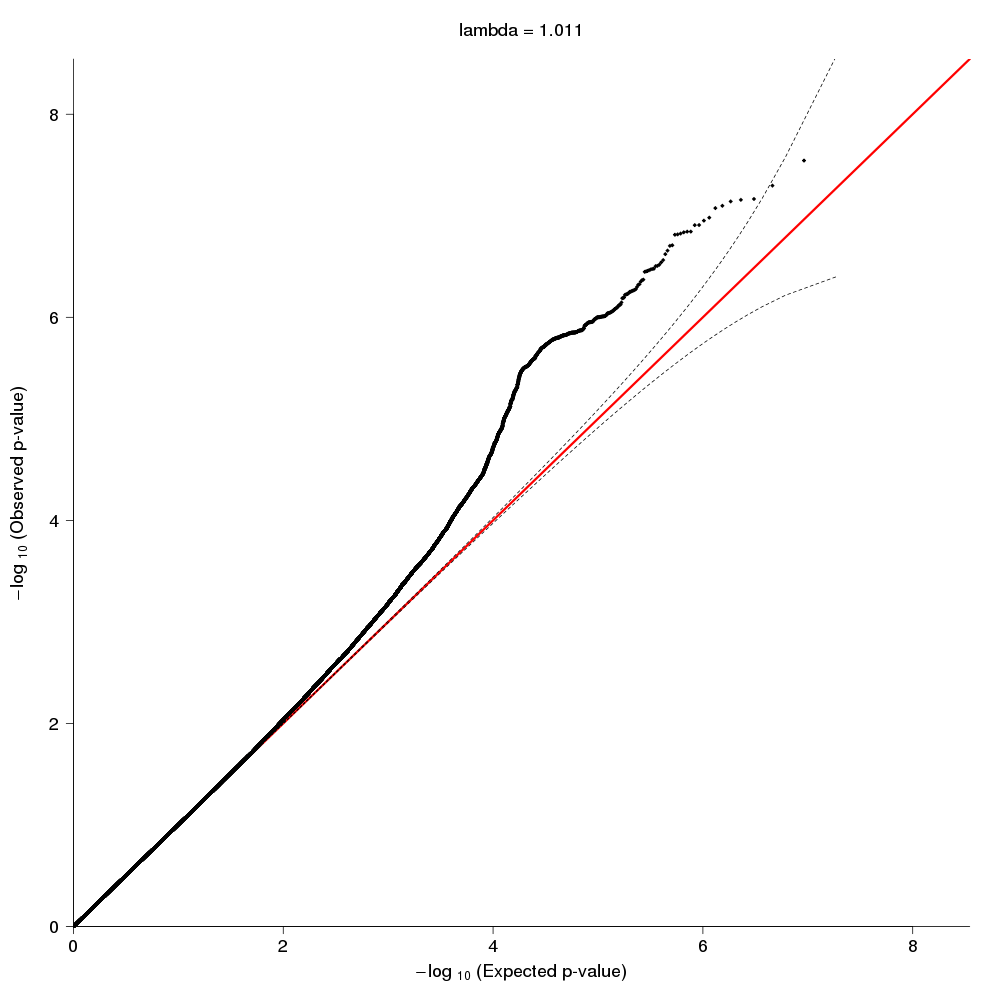

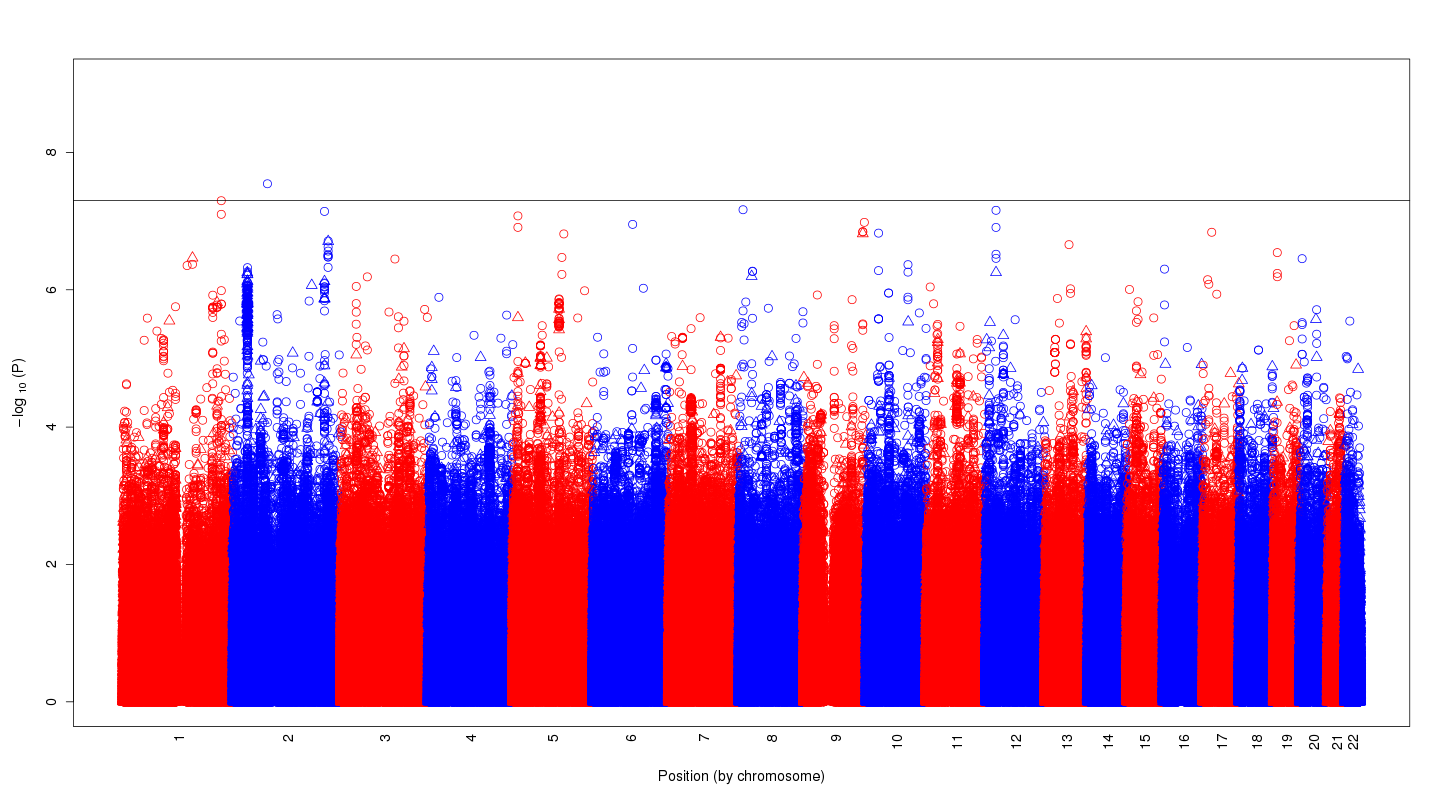

In [1]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Nicotine_Project/figures/nelson_277/nelson.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ.plots.snps+indels.qq.png")  
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Nicotine_Project/figures/nelson_277/nelson.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ.plots.snps+indels.manhattan.png")

# P-value Filter

In [ ]:
## EC2 ##
ancestry=ea
baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/final

outFile=$baseDir/nelson.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ.p_lte_0.001
head -n 1 $baseDir/nelson.ea.1000G_p3.chr9.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ > $outFile
    for (( chr=1; chr<23; chr++ )); do
        echo Processing $baseDir/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ
        tail -n +2 $baseDir/nelson.ea.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ |\
        perl -lane 'if ($F[15] <= 0.001) { print; }' >>  $outFile
done

In [ ]:
## Sort in R ##
#for (ancestry in c("ea","aa")){
for (ancestry in c("aa")){
    cohort="nelson"
    if (ancestry == "aa") { group = "afr" } else if (ancestry == "ea") { group = "eur" }
        dat=read.table(paste0('/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/final',
                      '/nelson.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ.p_lte_0.001'), header = TRUE)
        dat <- dat[order(dat$p),]
        write.csv(dat,
                  file=paste0('/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/final',
                  '/nelson.ea.1000G_p3.CAT_FTND~SNP+AGE+SEX+EVs.maf_gt_0.01_subject+eur.RSQ.p_lte_0.001.csv'),
                  row.names = FALSE, quote=F)
    }
## END Filter by p-value ###

# Scripts
## calculate_stats_for_probabel_results.R

* Note to replace the function `trim` with `trimws`.

* replace `model = "add" with model = "addA1"`

In [ ]:
#!/share/apps/R/bin/Rscript

completeCases = FALSE
fill = FALSE
model = "additive"
outputPvaluesOnly = FALSE
outputChi2Only = FALSE
chromosomes = c(1:22)

args <- commandArgs(TRUE)

loop = TRUE
while (loop) {
        if (args[1] == "--in_file") {
                fileIn = args[2]
        }

        # This should be the file name for the probabel results with "__CHR__" inserted where the chr # should be
        if (args[1] == "--in_template") {
                fileInTemplate = args[2]
        }

        if (args[1] == "--chromosomes") {
                if (args[2] == "autosomal") {
                        chromosomes = c(1:22)
                } else if (args[2] == "autosomal_nonPAR") {
                        chromosomes = c(1:23)
                }
        }

        if (args[1] == "--out_file") {
                fileOut = args[2]
        }

        if (args[1] == "--model") {
                model = args[2]
        }

        if (args[1] == "--complete_cases") {
                completeCases = TRUE
        }

        if (args[1] == "--fill") {
                fill = TRUE
        }

        if (args[1] == "--output_pvalues_only") {
                outputPvaluesOnly = TRUE
        }

        if (args[1] == "--output_chi2_only") {
                outputChi2Only = TRUE
        }

        if (length(args)>1) {
                args<-args[2:length(args)]
        } else {
                loop = FALSE
        }
}


if (exists("fileIn")) {
        cat("Reading ", fileIn, "...\n", sep="")
        results = read.table(fileIn, header = TRUE, na.strings = c("nan","NA"), fill = fill)
} else if (exists("fileInTemplate")) {
        for (chromosome in chromosomes) {
                fileIn = gsub("__CHR__",chromosome,fileInTemplate)
                cat("Reading ", fileIn, "...\n", sep="")
                nextResults = read.table(fileIn, header = TRUE, na.strings = c("nan","NA"), fill = fill)
                if (exists("results")) {
                        results = rbind(results, nextResults)
                } else {
                        results = nextResults
                }
        }
}

cat("Calculating stats...\n")
if (model == "additive") {
        model = "addA1"
} else if (model == "dominant") {
        model = "domA1"
}
beta = paste(sep = "", "beta_SNP_",model)
sebeta = paste(sep = "", "sebeta_SNP_",model)
results$chi = (results[,beta]/results[,sebeta])^2
results$p = pchisq(results$chi,df=1,lower=F)
if (completeCases) {
        results = results[complete.cases(results$p),]
}

if (outputPvaluesOnly) {
        results = results[c("name","p")]
} else if (outputChi2Only) {
  results = results[c("name","chi")]
} else {
        if (nrow(results) > 0) {
                results$significance[results$p >= 0.05] = ""
                results$significance[results$p < 0.05] = "*"
                results$significance[results$p < 0.01] = "**"
                results$significance[results$p < 0.001] = "***"
                results$or_95_percent_ci=paste(trim(formatC(exp(results[,beta]), format = "f", digits = 2)), "(", trim(formatC(exp(results[,beta] - (1.96 * results[,sebeta])), format = "f", digits = 2)), "-", trim(formatC(exp(results[,beta] + (1.96 * results[,sebeta])), format = "f", digits = 2)), ")", results$significance, sep = "")
                results$significance = NULL
        }
        if ("chrom" %in% colnames(results) & "position" %in% colnames(results)) {
                results = cbind(subset(results,select=c(name,chrom,position)),subset(results,select=-c(name,chrom,position)))
        } else if ("chrom" %in% colnames(results)) {
                results = cbind(subset(results,select=c(name,chrom)),subset(results,select=-c(name,chrom)))
        } else if ("position" %in% colnames(results)) {
                results = cbind(subset(results,select=c(name,position)),subset(results,select=-c(name,position)))
        }
}

cat("Writing ", fileOut, "...\n", sep="")
write.table(results, file = fileOut, row.names = FALSE, quote=FALSE, sep="\t")

cat("Done\n")



# Nextflow implementation (not used)

In [ ]:
#!/data/0212964/nextflow/nextflow-0.25.1-all

/* ######################################################################
#                 Association Pipeline v0.1                             #
###################################################################### */

/*
 * Defines pipeline parameters
 */

params.final_chunks = "The final chunking file splited by chromosome"
params.input_pheno = "The phenotype to be used in this analyses, file generated in ESN Windows environment"
params.imputation_dir = "The directory contains the post imputation genotype files (mldose files)"
params.example_mldose = "One of the mldose files in the imputation directory"
params.geno_prefix = "The prefix of the mldose file"
params.working_dirs = "The working directory"
params.out = "The output file name for the stats file"
params.method = "palinear or palogist"

/*
 * probabel_header = "name\tchrom\tposition\tA1\tA2\tFreq1\tMAF\tQuality\tRsq\tn\tMean_predictor_allele\tbeta_SNP_add\tsebeta_SNP_add\tchi2_SNP\tchi\tp\tor_95_percent_ci"
 */

// create chunks channels from chunking file
chunks = Channel
                        .from( file(params.final_chunks) )
                        .splitCsv(header:['chr', 'chunk', 'start', 'end'], skip: 1, sep: '\t')
chunks.into { chunks_prep_geno; chunks_merge; }

/* *********************************************
 * Step 1: Start Prepare ProbABEL Phenotype File
 */

process prepare_pheno{
 input:
        // input defined by parameters

        output:
        file "probabel_pheno" into probabel_phenotype_file

        """
        /share/nas03/bioinformatics_group/software/perl/prepare_probabel_files.pl \
                --in_mldose ${params.example_mldose} \
                --in_pheno ${params.input_pheno} \
                --out_pheno "probabel_pheno"
        """
}

/* ********************************************
 * Step 2: Start Prepare ProbABEL Genotype File
 */

process prepare_geno{

        input:
        file "probabel_pheno" from probabel_phenotype_file
        set chr, chunk, start, end from chunks_prep_geno

        output:
        file "${params.geno_prefix}${chr}.${chunk}.mach_mldose" into probabel_genotype_files

    executor 'sge'
    clusterOptions '-S /bin/bash -l mem_free=15G,h_vmem=15G -p 0'

        """
        /share/nas03/bioinformatics_group/software/perl/prepare_probabel_files.pl \
                --in_mldose "${params.imputation_dir}/${params.geno_prefix}${chr}.${chunk}.mach.mldose.gz" \
                --in_pheno "${probabel_pheno}" \
                --out_mldose "${params.geno_prefix}${chr}.${chunk}.mach_mldose"
        """
}

/* *******************************
 * Step 3: Start ProbABEL Analysis
 */

process do_probabel_analysis{

        input:
        file probabel_pheno from probabel_phenotype_file
        file geno from probabel_genotype_files

        output:
        file "${geno.baseName}_add.out.txt" into probabel_out_files

        executor 'sge'
    clusterOptions '-S /bin/bash -l mem_free=7G,h_vmem=7G -p 0'

        """
        /share/nas03/bioinformatics_group/software/${params.method} \
        --pheno $probabel_pheno \
        --dose $geno \
        --info "${params.imputation_dir}/${geno.baseName}.mach.mlinfo" \
        --map "${params.imputation_dir}/${geno.baseName}.legend" \
        --out "${geno.baseName}"
        """
}

/* ***************************
 * Step 4: Start calc chi p OR
 */
process calc_chi_p_or{

        input:
        file result from probabel_out_files

        output:
        file "${result.baseName}.stats" into stats_files

        executor 'sge'
    clusterOptions '-S /bin/bash -l mem_free=7G,h_vmem=7G -p 0'

        """
        /share/nas03/bioinformatics_group/software/R/calculate_stats_for_probabel_results_v2.R \
                --remove_missing_p \
                --in_file "${result}" \
                --out_file "${result.baseName}.stats"
        """
}

/* ***************************
 * Step 5: merge stats files
 */

stats_files
        .collectFile(name: file(params.out), skip: 1)
        .println {"Result saved to file: $it"}


# Upload to S3

In [ ]:
imputeDir=/shared/data/studies/nelson/imputed/v1/imputations/ea
resultsDir=/shared/bioinformatics/jmarks/nicotine/gwas/nelson/association_tests/002/ea/final

aws s3 sync $imputeDir s3://rti-nd/nelson/data/imputed/ea/ --quiet &
aws s3 sync $resultsDir s3://rti-nd/nelson/results --quiet &